In [22]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor

import sys

sys.path.append('../okko')
from data_preprocess import load_and_preprocess_data

In [3]:
(train_x, train_y, test_x) = load_and_preprocess_data()

In [26]:
def PCA_component_selection(
        model,
        X_train: pd.DataFrame,
        y_train: pd.Series):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    best_r2 = -2
    r2_scores = []
    mse_scores = []

    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

    for n_components in range(1,X_train_scaled.shape[1] + 1):
        pca = PCA(n_components=n_components)
        Xpca = pca.fit_transform(X_train_scaled)
        scores = cross_validate(
            model,
            Xpca,
            y_train_scaled,
            scoring={'r2': 'r2', 'mse': 'neg_mean_squared_error'},
            cv=kf,
            n_jobs=-1
        )
        r2_scores.append(np.mean(scores['test_r2']))
        mse_scores.append(np.mean(scores['test_mse']))
    return {"Num_of_Components":[range(1,X_train_scaled.shape[1] + 1)], "r2_scores":r2_scores, "mse_scores":mse_scores}            

In [27]:
models = {"Dummy": DummyRegressor(strategy='mean'),
          "RandomForest": RandomForestRegressor(n_jobs=-1),
          "SVR": SVR(),
          "GradientBoosting": HistGradientBoostingRegressor()}

In [29]:
results = []
for name,model in models.items():
    result = PCA_component_selection(model,train_x,train_y)
    result["Model"] = name
    results.append(result)


In [31]:
best_components = []

for result in results:
    num_components = list(range(1, len(result["r2_scores"]) + 1))
    
    best_r2_idx = np.argmax(result["r2_scores"])
    best_mse_idx = np.argmax(result["mse_scores"])
    
    best_components.append({
        "Model": result["Model"],
        "Best_r2_components": num_components[best_r2_idx],
        "Best_r2_score": result["r2_scores"][best_r2_idx],
        "Best_mse_components": num_components[best_mse_idx],
        "Best_mse_score": result["mse_scores"][best_mse_idx]
    })

best_components_df = pd.DataFrame(best_components)
best_components_df.to_csv("best_components_results.csv", index=False)

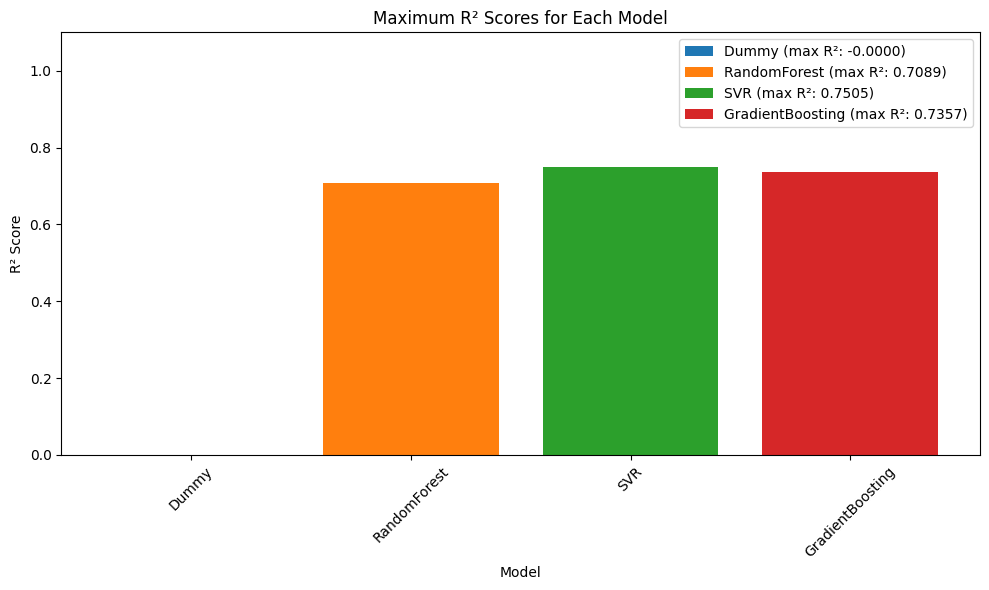

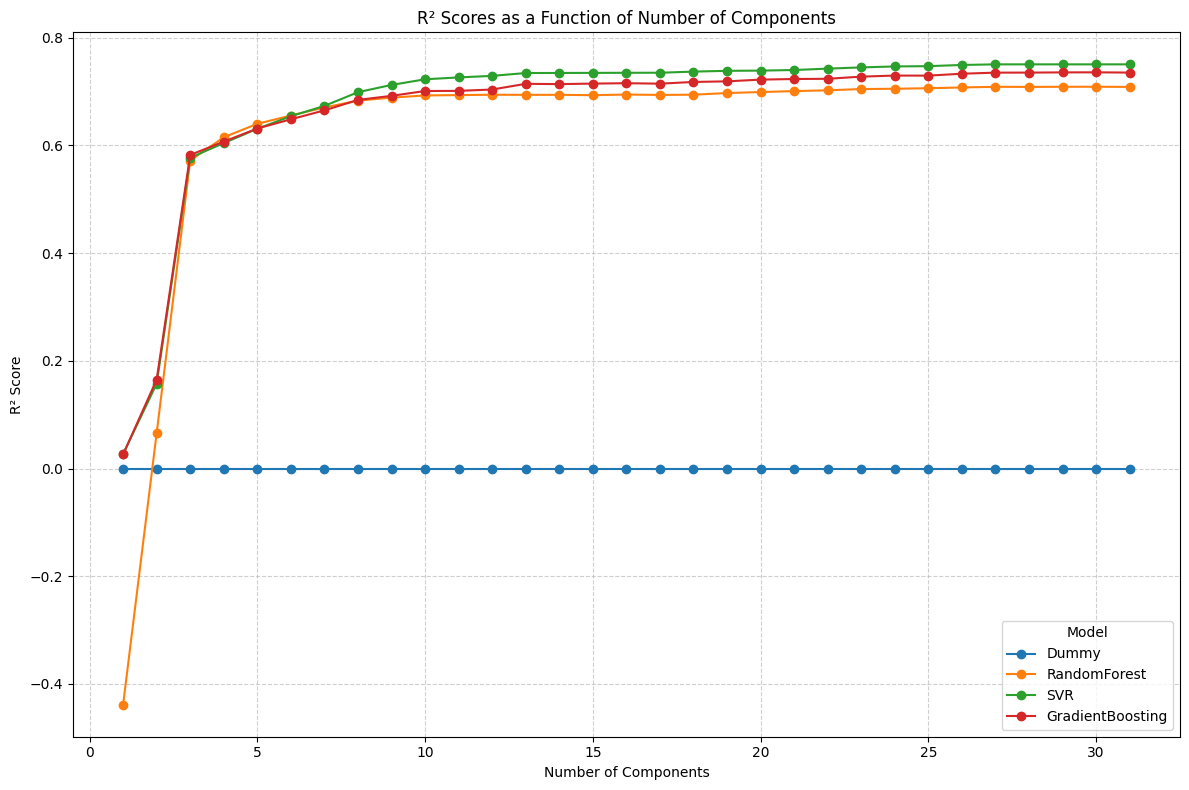

In [32]:
import matplotlib.pyplot as plt

models = [result["Model"] for result in results]
num_components = range(1, train_x.shape[1] + 1)
r2_scores_by_model = [result["r2_scores"] for result in results]

plt.figure(figsize=(10, 6))
for model, r2_scores in zip(models, r2_scores_by_model):
    plt.bar(model, max(r2_scores), label=f"{model} (max R²: {max(r2_scores):.4f})")

plt.title("Maximum R² Scores for Each Model")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1.1)  
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for model, r2_scores in zip(models, r2_scores_by_model):
    plt.plot(num_components, r2_scores, label=model, marker='o')

plt.title("R² Scores as a Function of Number of Components")
plt.ylabel("R² Score")
plt.xlabel("Number of Components")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()

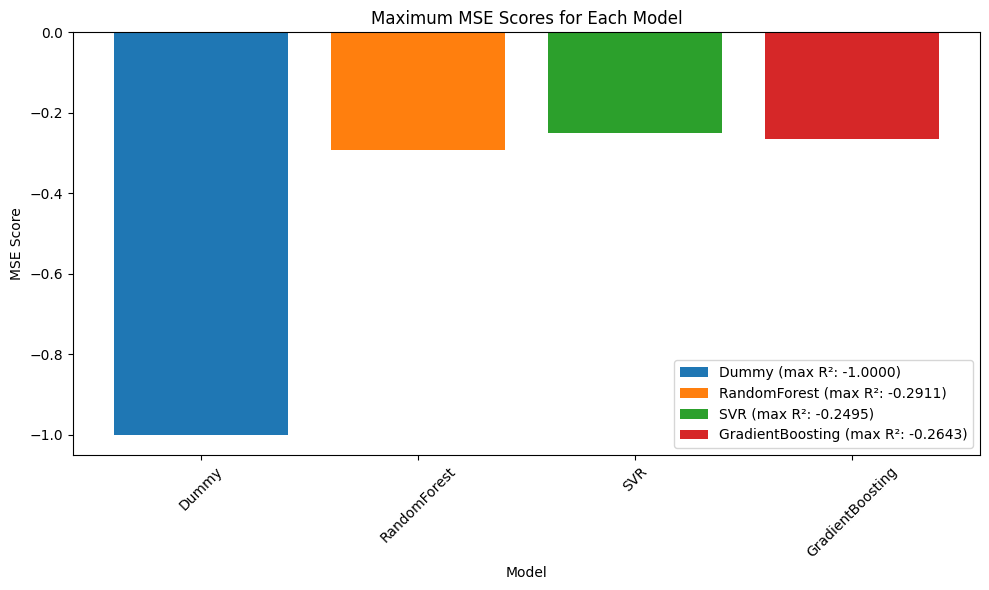

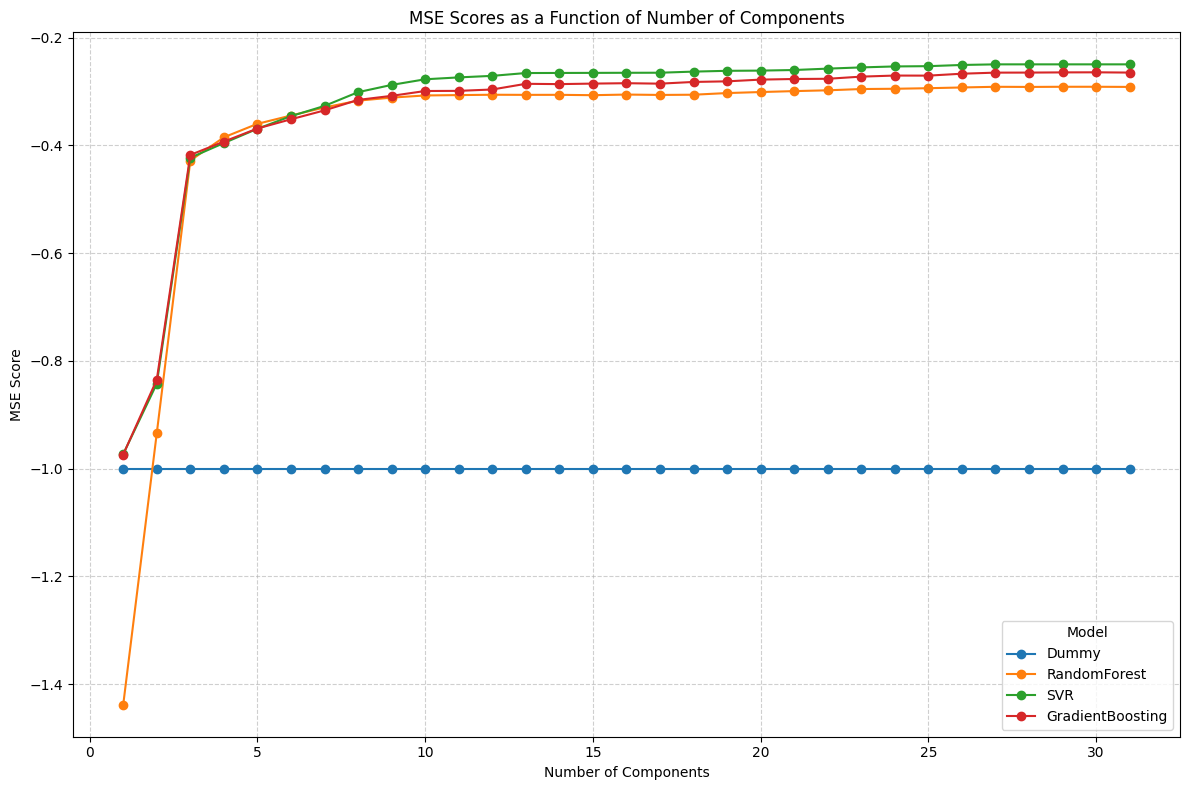

In [36]:
models = [result["Model"] for result in results]
num_components = range(1, train_x.shape[1] + 1)
mse_scores_by_model = [result["mse_scores"] for result in results]

plt.figure(figsize=(10, 6))
for model, mse_scores in zip(models, mse_scores_by_model):
    plt.bar(model, max(mse_scores), label=f"{model} (max R²: {max(mse_scores):.4f})")

plt.title("Maximum MSE Scores for Each Model")
plt.ylabel("MSE Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for model, mse_scores in zip(models, mse_scores_by_model):
    plt.plot(num_components, mse_scores, label=model, marker='o')

plt.title("MSE Scores as a Function of Number of Components")
plt.ylabel("MSE Score")
plt.xlabel("Number of Components")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()